# Equvariant Neural Networks

```{danger}
This chapter is being written
```

The previous chapter {doc}`data` discussed data transformation and network architecture decisions that can be made to make a neural network equivariant with respect to translation, rotation, and permutations. However, those ideas limit the expressibility of our networks and are constructed ad-hoc. Now we will take a more systematic approach to defining equivariances and prove that there is only one layer type that can preserve a given equivariance. The result of this section will be layers that can be equivariant with respect to any transform, even for more esoteric cases like points on a sphere or mirror operations. To achieve this, we will need tools from group theory, representation theory, harmonic analysis, and deep learning.


## Do you need equivariance?


```{margin}
I'm being a bit unfair, these papers have some slightly different application areas (lie vs compact vs finite groups) and differ mostly in their non-linearity. However, it can be hard to discern what is truly different about these papers because of the differences in their derivations.
```

Before we get too far, let me first try to talk you out of equivariant networks. The math required is advanced, especially because the theory of these is still in flux. There are four papers in the last few years that propose a general theory for equivariant networks and they each take a slightly different approach {cite}`finzi2020generalizing,cohen2019general,kondor2018generalization,lang2020wigner`. It is also easy to make mistakes in implementations due to the complexity of the methods. You also must do implementations (as of 2020) because there are no efficient general implementations for equivariant networks. You will also find that equivariant networks do not beat generally beat state of the art models on many of the tasks they're design for -- although that is now quickly changing at the end of 2020 with recent benchmarks set in point cloud segmentation {cite}`wang2020equivariant`, molecular force field prediction {cite}`batzner2021se3equivariant`, and molecular energy predictions {cite}`klicpera2020directional`.

Alternatives to equivariant networks are training and testing augmentation. Both are powerful methods for many domains and are easy to implement. You can also do data transformations like discussed in {doc}`data` to avoid equivariance. So why would you study this chapter? I think these ideas are important and incorporating the equivariant layers into other network architectures can dramatically reduce parameter numbers and training efficiency.


## Running This Notebook


Click the &nbsp;<i aria-label="Launch interactive content" class="fas fa-rocket"></i>&nbsp; above to launch this page as an interactive Google Colab. See details below on installing packages, either on your own environment or on Google Colab

````{tip} My title
:class: dropdown
To install packages, execute this code in a new cell

```
!pip install matplotlib numpy pandas seaborn jax jaxlib
```

````

### Outline

We have to lay some mathematical foundations before we can grasp the equations and details of equivariant networks. We'll start with a brief overview of group theory so we can define the principle of equivariance generally. Then we'll show how any equivariance can be enforced in a neural network via a generalization of convolutions. Then we'll visit representation theory to see how to encode groups into matrices.  Then we'll see how these convolutions can be more easily represented using the generalization of Fourier transforms. Finally, we'll see some of the special details when looking at equivariances of permutations. Throughout this chapter we'll see three examples that capture some of the different settings. Remember, that I am a chemical engineer so that some of this chapter will probably have reckless math. 

## Group Theory

A modern treatment of group theory can be found in {cite}`zee2016`. A group is a general object in mathematics. A group is a set of elements that can be combined in a binary operation whose output is another member of the group. The most common example are the integers. If you combine two integers in a binary operation, the output is another integer. Of course, it depends on the operation ($1 \div 2$ does not give an integer), so specifically consider addition. Integers are not the example we care about though. We're interested in groups of **transformations** that move points in a space. Operations like rotation, scaling, mirroring, or translating of single points. As you read about groups here, remember that the elements of the groups are *not* numbers or points. The group elements are transformations that act on points in the space. Notice I'm being a bit nebulous on what the space is for now. Let's first define a group: 

```{admonition} Group Definition
A group $G$ is a set of elements (e.g., $\{a, b, c, i, e\}$) equipped with a binary operation ($a\cdot{}b = c$) whose output is another group element and the following conditions are satisfied:

1. **Closure** The output of the binary operation is always a member of the group
2. **Associativity** $(a\cdot{}b)\cdot{}c = a\cdot{}(b\cdot{}c)$
3. **Identity** There is a single identity element $e$ such that $ex = x \forall x \in G$
4. **Inverse** There exists exactly one inverse element $i$ for each $x$ such that $xi = e$
```

This is quite a bit of nice structure. We always have an inverse available. Applying the binary operations never accidentally leaves our group. One important property that is missing from this list is **commutativity**. In general, a group is not commutative so that $a\cdot{}b \neq b\cdot{}a$. If the group does have this extra property, we call the group **abelian**. Another detail is how big the set is. It can indeed be infinite, which is why the integers or all possible rotations of a sphere can be represented as a group. One notational convenience we'll make is that the binary operation "$\cdot{}$" will just be referred to as multiplication. The number of elements in a group $|G|$ is known as the **order**.

```{margin}
If you multiply two transforms $a\cdot{}b$, we always apply $b$ first and then $a$. This is important to remember for non-commutative groups (non-abelian). 
```

The point of introducing the groups is so that they can transforms elements of our space. This is done through a **group action**

```{admonition} Group Action
A group action $\phi(g, v)$ is a mapping from a group $G$ and a space $\mathcal{X}$ to the space $\mathcal{X}$:

\begin{equation}
\phi: G\times \mathcal{X}\rightarrow \mathcal{X}
\end{equation}
```

So a group action takes in two arguments (binary): a group element and a point in a space $\mathcal{X}$ and transforms the point to a new one: $\phi(g, x_0) = x_1$. This is just a more systematic way of saying it transforms a point. The group action is neither unique to the space nor group. Often we'll omit the function notation for the group action and just write $gx = x'$. 

Let's introduce our three example groups that we'll refer to throughout this chapter.


### ⬡ Finite Group $Z_6$ 

The first group is about rotations of a hexagon {glue:}`hex-6`. Our basic group member will be rotating the hexagon enough to shift all the vertices: {glue:}`hex-0` $\rightarrow$ {glue:}`hex-1`. Notice I've colored the vertices and added a line so we can easily distinguish the orientation of the hexagon. Remember the hexagon, its colors, and if it is actually symmetric have nothing to do with the group. *The group elements are transformations we apply to the hexagon*.

One group action for this example can use modular arithmetic. If we represent a point in our space as $\left\{0,\ldots, 5\right\}$ then the rotation transformation is $x' = x + 1 \;(\bmod\; 6)$. For example, if we start at $5$ and rotate, we get back to $0$. 

Our group must contain our rotation transformation $r$ and the identity: $\{e, r\}$. This set is not closed though: rotating twice $r\cdot{}r$ {glue:}`hex-0` $\rightarrow$ {glue:}`hex-1` $\rightarrow$ {glue:}`hex-2` gives a new group element $r^2$. To close the group we need to have $\{e, r, r^2, r^3, r^4, r^5\}$. 

Is this closed? Consider rotating twice and then five times $r^2\cdot{}r^5$ {glue:}`hex-0` $\rightarrow$ {glue:}`hex-2` $\rightarrow$ {glue:}`hex-1` You can see that this is the same as $r$, so $r^2\cdot{}r^5 = r$. What about the inverses element? The inverse of $r$ is $r^5$. $r\cdot{}r^5 = e$. You can indeed see that each element has an inverse ($e$ is its own inverse).

In general, we can write out the group as a multiplication table that conveys all group elements and defines the output of all binary outputs:

$$
\begin{array}{l|cccccr}
& e & r & r^2 & r^3 & r^4 & r^5\\
\hline
e & e & r & r^2 & r^3 & r^4 & r^5\\
r & r & r^2 & r^3 & r^4 & r^5 & e\\
r^2 & r^2 & r^3 & r^4 & r^5 & e & r\\
r^3 & r^3 & r^4 & r^5 & e & r & r^2\\
r^4 & r^4 & r^5 & e & r & r^2 & r^3\\
r^5 & r^5 & e & r & r^2 & r^3 & r^4\\
\end{array}
$$

You can also see that the group is abelian (commutative). For example, $r\cdot{}r^3 = r^3\cdot{}r$. 

This group is an example of a **cyclic group** and is isomorphic (same transofmrations, but operates on different objects) to integers modulo 6. Meaning, you could view rotation $r^n$ as operating on integers $(x + n) \textrm{mod}\, 6$. Cyclic groups are written as $Z_n$, so this group is $Z_6$. 


### ▩ p4m
 
```{margin}
p4m strictly speaking only includes integer translations but many of the principles apply for continuous infinte groups (locally compact) and integer (countably) infinite groups
```

The second group contains translation, 90° rotations, and  horizontal/vertical mirroring. We're now operating on real numbers $x,y$, so we're in $\mathbb{R}^2$. Let's ignore the translation for now and just consider mirroring ($s$) and rotation by 90° ($r$) about the origin. What powers of $r$ and $s$ do we need to have a closed group? Considering rotations alone first, like last time we should only need up to $r^3$. Here are the rotations visually: {glue:}`quad-0-0`, {glue:}`quad-1-0`, {glue:}`quad-2-0`, {glue:}`quad-3-0` What about mirroring on horizontal/vertical? Mirroring along the horizontal axis: {glue:}`quad-0-0` $\rightarrow$ {glue:}`quad-2-1` is actually the same as rotating twice and then mirroring along the vertical. In fact, you only need to have mirroing along one axis. We'll choose the vertical axis by convention and denote that as $s$.

We can build the group action piece by piece. The group action for rotation can be represented as a 2D rotation matrix acting a point $(x, y)$:

$$
\left[\begin{array}{lr}
\cos\frac{k2\pi}{4} & -\sin\frac{k2\pi}{4}\\
\sin\frac{k2\pi}{4} & \cos\frac{k2\pi}{4}\\
\end{array}\right]
\left[\begin{array}{c}
x\\
y\\
\end{array}\right]
,\, k \in \left\{0, 1, 2, 3\right\}
$$

where $k$ can allow us to do two rotations at once ($k = 2$) or the identity ($k = 0$). The vertical axis mirror action can be represented by 

$$
\left[\begin{array}{lr}
1 & 0\\
0 & -1\\
\end{array}\right]
\left[\begin{array}{c}
x\\
y\\
\end{array}\right]
$$

These two group actions can be ordered to correctly represent rotation then mirroring or vice-versa.


Now is this closed with the group elements $\{e, r, r^2, r^3, s\}$? Visually we have  {glue:}`quad-0-0`, {glue:}`quad-1-0`, {glue:}`quad-2-0`, {glue:}`quad-3-0`, {glue:}`quad-0-1`? No. Consider $r^2\cdot{}s$ {glue:}`quad-0-0` $\rightarrow$ {glue:}`quad-0-1` $\rightarrow$ {glue:}`quad-2-1` which is not an element. To close the group, we need $\{e, r, r^2, r^3, s, rs, r^2s, r^3s\}$. The multiplication table (which defines the elements too) is:

$$
\begin{array}{l|cccccccr}
& e & r & r^2 & r^3 & s & rs & r^2s & r^3s\\
\hline
e & e & r & r^2 & r^3 & s & rs & rs^2 & rs^3\\
r & r & r^2 & r^3 & e & rs & r^2s & r^3s & s\\
r^2 & r^3 & e & r & r^2 & r^2s & r^3s & s & rs\\
r^3 & e & r & r^2 & r^3 & r^3s & s & rs & r^2s\\
s & s & r^3s & r^2s & rs & e & r^3 & r^2 & r\\
rs & rs & s & r^3s & r^2s & r & e & r^3 & r^2\\
r^2s & r^2s & rs & s & r^3s & r^2 & r & e & r^3\\
r^3s & r^3s & r^2s & rs & s & r^3 & r^2 & r & e\\
\end{array}
$$

As you can see from the  table, the group is closed. Remember, elements like $rs$ are not a binary operation. They are group elements. We can also see that the group is not commutative. $r\cdot{}s$ is {glue:}`quad-0-0` $\rightarrow$ {glue:}`quad-0-1` $\rightarrow$ {glue:}`quad-1-1`, so $r\cdot{}s = rs$ as expected. However, $s\cdot{}r$ is {glue:}`quad-0-0` $\rightarrow$ {glue:}`quad-1-0` $\rightarrow$ {glue:}`quad-3-1`, which is the group element $r^3s$.

We can also read the inverses off the table. For example, the inverse of $r$ is the column which gives the identity element: $r^3$. This group is known as the dihedral group 4 $D_4$. It has order 8. 

Now consider the translation group elements. For simplicity, let's only consider integer translations. We can label them as $t_{w,h}$. So $t_{3,4}$ means translate by $x + 3$ and $y + 4$. Is this a proper group? Certainly it associative, there is an identity $t_{0,0}$ and an inverse for each element $t_{-x, -y}$. What about closure? Yes, since translating twice is equivalent to one larger translation: $t_{w,h}\cdot{}t_{w', h'} = t_{w + w', h + h'}$. This expression also shows group action for translation. 

What about when we combine with our other elements from the $D_4$ group? Consider the product $r\cdot{}t_{3,4}$. This means translating by $(3,4)$ and then rotating by 90° about the origin. If you consider this acting on a single point $(0,0)$, you could get $(0,0) \rightarrow (3,4) \rightarrow (-3,4)$. What element of our group would this represent? At first it seems like it could be $t_{-3,4}$. However, $t_{-3,4}$ would only work specifically for starting at $(0,0)$. If you started at $(1,1)$, you would get to $(-4,5)$ with $r\cdot{}t_{3,4}$ and $(-2,5)$ with $t_{-3,4}$. To be correct for *any point*, we need a different group element. So the product $r\cdot{}t_{3,4}$ actually cannot be a product but instead must be a group element. In fact, our new combined group is just going to be $ab$ where $a$ is an element from $D_4$ and $b$ is a translation. Thus $r\cdot{}t_{3,4} = rt_{3,4}$. 

Combing these two groups, the translation and $D_4$, is an example of a **semidirect product**. A semidirect product just means that we create a new group by combining all possible group elements. There is some machinery for this, like the identity element in our new group is something like $et_{0,0}$, and it has some other structure. It is called semidirect, instead of direct, because we can actually mix our group elements. The elements both act on points in the same space ($x,y$ plane), so this make sense. Another condition is that we can only have a semidirect product when one subgroup is normal and the translation subgroup is the normal subgroup. It is coincidentally abelian, but these two properties are not always identical. This semidirect product group is called p4m.

Below, is an optional section that formalizes the idea of combining these two groups into one larger group.


```{admonition} Normal Subgroup
A normal subgroup is a group of elements $n$ from the group $G$ called $N$. Each $n \in N$ should have the property that $g\cdot{}n\cdot{}g^{-1}$ gives an element in $N$ for any $g$.  
```

This does not mean $g\cdot{}n\cdot{}g^{-1} = n$, but instead that $g\cdot{}n\cdot{}g^{-1} = n'$ where $n'$ is some other element in $N$. For example, in p4m the translations form a normal subgroup. Rotating, translating, then doing the inverse of the rotation is equivalent to some translation. Notice that $D_4$ is not a normal subgroup of p4m. If you do an inverse translation, rotate, then do a translation you may not have something equivalent to a rotation. It may be strange that we're talking about the group p4m when we haven't yet described how it's defined (identity, inverse, binary op). We'll do that with the semidirect product and then we could go back and verify that the translations are a normal subgroup more rigorously. I do not know the exact connection, but it seems that normal subgroups are typically abelian. 

```{admonition} Semidirect Product
Given a normal subgroup of $G$ called $N$ and a subrgoup $H$, we can define $G$ using the semidirect product. Each element in $G$ is a tuple of two elements in $N, H$ written as $(n, h)$. The identity is $(e_n, e_h)$ and the binary operation is:

\begin{equation}
(n_1, h_1) \cdot (n_2, h_2) = (n_1\cdot\phi(h_1)(n_1), h_1\cdot{}h_2)
\end{equation}

where $\phi(h)(n)$ is the conjugation of $n$ $\phi(h)(n) = h\cdot{}n\cdot{}h^{-1}$. When a transform $(n,h)$ is applied, we follow the normal convention that $h$ is applied first followed by $n$. 
```

We are technically doing an outter semidirect product: combining them under the assumption that both $D_4$ and $T$ are part of a larger group which contains both. This is a bit of a semantic detail, but they are actually both part of $p4m$ and a larger group called the affine group which includes translation, rotation, shear, translation, mirror, and scale operations on points. You could also argue they are part of groups which can be represented by 3x3 invertible matrices. Thus, you can combine these and get something that is still smaller than their larger containing group ($p4m$ is smaller than all affine transformations).

One consequence of the semidirect product is that if you have a group element $(n,h)$ but want to instead apply $n$ first (instead of $h$), you can use the binary operation:


\begin{equation}
(e_n, h) \cdot (n, e_h) = (e_n\cdot\phi(h)(n), h\cdot{}e_h) = (\phi(h)(n), h)
\end{equation}


so $\phi(h)(n)$ somehow captures the effect of switching the order applying elements from $H$ and $N$. In our case, this means swapping the order of rotation/mirroring and translation. 

To show what effect the semidirect product has in p4m, we can clean-up our example above about $r\cdot{}t_{3,4}$. We should write the first element of this binary product $r$ as a tuple of group elements: one from the $D_4$ and one from the translations. Since there is no translation for $r$, we use the identity. Thus we write $r$ as $(t_{0,0}, r)$ in our semidirect product group p4m. Note that the normal subgroup comes first (applied last) by convention. Similarly, $t_{3,4}$ is written as $(t_{3,4}, e)$. Our equation becomes:

$$
(t_{0,0}, r)\cdot(t_{3,4}, e) = (t_{0,0}\cdot\phi(r)(t_{3,4}), r\cdot{}e) = (t_{0,0}\cdot\phi(r)(t_{3,4}), r)
$$

where $\phi$ is the automorphism that distinguishes a semidirect product from a direct product. The direct product has $\phi(h)(n) = n$ so that the binary operation for the direct product group is just the element-wise binary products. $\phi(h)(n) = hnh^{-1}$ for semidirect products. In our equation, this means $\phi(r)(t_{3,4}) = r\cdot{}t_{3,4}\cdot{}r^3$. Substituting this and using the fact that both groups have the same binary operation (matrix multiplication, as we'll see shortly):

$$
(t_{3,4}\phi(r)(t_{3,4}), r) = (r\cdot{}t_{3,4}\cdot{}r^3, r) = r\cdot{}t_{3,4}\cdot{}r^3\cdot r = r\cdot{}t_{3,4}
$$

Thus we've proved that translating by $3,4$ followed by rotating can be expressed as $r\cdot{}t_{3,4}$, which seems like a lot of work for an obvious result. I won't cover the semidirect product of the group action, but we'll see that we do not necessarily need to build a group action encapsulating both translation and rotation/mirroring. 



###  ⚽ SO(3) Lie Group

SO(3) is one of the most difficult groups to work with but is critical for analyzing 3D point clouds like trajectories. SO(3) is the group of all rotations about the origin in 3D. The group is non-abelian because rotations in 3D are not commutative. The group order is infinite, because you can rotate in this group by any angle (or sets of angles). If you are interested in allowing translations, you can use SE(3) which is the semidirect product of SO(3) and the translation group (like p4m), which is a normal subgroup. 

The SO(3) name is a bit strange. SO stands for "special orthogonal" which are two properties of square matrices. In this case, the matrices are $3\times3$. Orthogonal  means the columns sum to one and special means the determinant is 1. Interestingly, all rotations in 3D around the origin are also the SO(3) matrices. 

One detail is that since we're rotating (no scale or translation) *our points will all be on a sphere*. We cannot move the radius. By convention then we'll have a radius 1. The group action is the product of 3 3D rotation matrices $R_z(\alpha)R_y(\beta)R_z(\gamma)$ where $\alpha, \beta, \gamma \in [0, 2\pi]$ and

$$
R_z(\theta) = \left[\begin{array}{lcr}
\cos\theta & -\sin\theta & 0\\
\sin\theta & \cos\theta & 0\\
0 & 0 & 1\\
\end{array}\right]
$$

$$
R_y(\theta) = \left[\begin{array}{lcr}
\cos\theta & 0 & \sin\theta \\
0 & 1 & 0\\
-\sin\theta &  0 & \cos\theta\\
\end{array}\right]
$$

### Groups on Spaces

We've defined transforms and their relationships to one another via group theory. Now we need to actually connect the transforms to a space. It is helpful to think about the space as Euclidean with a concept of distance and coordinates, but we'll see that this is not required. Our space could be vertices on a graph or integers or classes. There are *some* requirements though. The first is that our space must be **homogeneous**. Homogeneous means that from any point in our space $x$ we can reach any other point with a transform $g$ from our group $G$. The second requirement is that if our group is infinite, the space must **compact**. Compactness is a concept from topology and essentially means that the space is smooth and differentiable. This is true of most spaces we'll see in chemistry or materials science, except there may be issues at poles on a sphere or other singular points. This doesn't matter for finite groups, so we can use non-compact spaces like vertices on a graph for finite groups. If the group transforms are further smooth and have smooth inverses, the group (and associated space) are called a **lie group**. 

```{margin}
The lie group definition is a side-note, it has nothing to do with our analysis.
```

```{tabbed} ⬡ Finite Group $Z_6$ 

The space is homogeneous because our group includes "compound" rotations like $r^4$. This is a finite group, so we do not require the space to be compact. 

```

```{tabbed} ▩ Locally Compact p4m

The space is homogeneous since we can use a translation to get to any other point. The space is locally compact because we are in 2D Euclidean geometry. It is not a lie group, because the dihedral operations (rotate/mirror) are not smooth. Or at least I don't think so, I don't know enough about topology. 

```

```{tabbed} ⚽ SO(3) Lie Group

The space is homogeneous because we restrict ourselves to being on the sphere. The space is locally compact because we are in 3D Euclidean geometry. This is a lie group because the transformations are continuous and smooth. 

```

This may seem like a ton of work. We could have just started with $xyz$ coordinates and rotation matrices. Please continue to wait though, we're about to see something incredible.

## Equivariance Definition

You should be thinking now about how we can define equivariance using our new groups. That's where we're headed. We need to do a bit of work now to "lift" neural networks and our features into the framework we're building. First, in {doc}`data` we defined our features as being composed of tuples $(\vec{r}_i, \vec{x}_i)$ where $\vec{r}_i$ is a spatial point and $\vec{x}_i$ are the features at that point. Let's now view these input data as functions, defined as $f(\vec{r}) = \vec{x}$ and assume if a point $\vec{r}'$ isn't in our training data then $f(\vec{r}') = \vec{0}$. More formally, our training data is a function $f:\mathcal{X} \rightarrow \mathbb{R}^n$ that maps from our homogeneous space $\mathcal{x}$ to real vector (or complex vectors) of dimension $n$. 

We have promoted our data into a function and now a neural network can no longer be just function since its input is a function. Our neural network will be also promoted to an **linear map**, which has an input of a function and an output of a function. Formally, our network $\psi: f(\mathcal{X}) \rightarrow f'(\mathcal{X})$. Notice the input and output spaces of the functions should be the same (we cannot switch from 2D to 3D). Linear maps are also called **operators**, depending on which branch of mathematics you're in.

The last piece of equivariance is to promote our group elements, which transform points, to work on functions.

```{admonition} G-Function Transform Definition
An element $g$ of group $G$ on the homogeneous space $\mathcal{X}$ can act on a function $f:\mathcal{X}\rightarrow \mathbb{R}^n$ via the group transform linear map $\mathbb{T}_g: f(\mathcal{X}) \rightarrow f'(\mathcal{X})$ defined as 

\begin{equation}
f'(gx) = f(x) \Rightarrow f'(x) = f(g^{-1}x)
\end{equation}
```

This definition takes a moment to think about. Consider a translation of an image. You want to move an image to the left by 10 pixels, so $g = t_{10,0}$. The image is defined by the function $f(x,y) = (r, g, b)$, where $r,g,b$ is the color. We want $T_g f(x, y)$. Without knowing about groups, you can intuit that translating can be done by creating a new function $f'(x', y') = f(x - 10, y)$. Notice that the inverse of $g^{-1} = t_{-10, 0}$ acts on the points, not $g$. Recall that a group requires there to be an inverse for any group element.

Now we have all the pieces to define an equivariant neural network:

```{admonition} Equivariant Neural Network Definition
Given a group $G$ on a homogeneous space $\mathcal{X}$, a G-covariant neural network is linear map $\psi: f(\mathcal{X}) \rightarrow f'(\mathcal{X})$ that has the property{cite}`kondor2018generalization`:

\begin{equation}
\psi\left[\mathbb{T}_g f(x)\right] = \mathbb{T}_{g'}\psi\left[f(x)\right]\;\forall\, f
\end{equation}

If $g = g'$, the $\psi$ is a G-equivariant neural network. If $g = g' = e$, the identity, then $\psi$ is a G-invariant neural network.
```

Note **covariant** is a rarely used term; I only include it to distinguish between the general case of $g \neq g'$ and the much more common $g = g'$ equivariant case. The definition means that we get the same output if we transform the input function to the neural network or transform the output (in the equivariant case). In a specific example, if we rotate the input by 90 degrees, that's the same result as rotating the output by 90 degrees. Take a moment to ensure that matches your idea of what equivariance means. After all this math, we've generalized equivariance to arbitrary spaces and groups.


## G-Equivariant Convolution Layers

Kondor and Trivedi showed that there is *only one* way to make a G-equivariant neural network:

```{admonition} G-Equivariant Convolution Theorem
A neural network layer (linear map) $\psi$ is G-equivariant if and only if its form is a convolution operator $*$ 

\begin{equation}
\label{discconv}
\psi(f) = (f * \phi)(u) = \sum_{g \in G} f\uparrow^G\left(ug^{-1}\right)\phi\uparrow^G\left(g\right)
\end{equation}

where $f: H \rightarrow \mathbb{R}^n$ and $\phi: H' \rightarrow \mathbb{R}^n$ are functions of quotient spaces $H$ and $H'$. If the group $G$ is locally compact (infinite elements), then the convolution operator is

\begin{equation}
\label{cont-conv}
\psi(f) = (f * \phi)(u) = \int_G f\uparrow^G\left(ug^{-1}\right)\phi\uparrow^G\left(g\right)\,d\mu(g)
\end{equation}

where $\mu$ is the group Haar measure. 

```
```{margin}
This is one of the strongest theorems in deep learning. It says there is only one way to achieve equivariance in a neural network. This may seem counter-intuitive since there are many competing approaches to convolutions. These other approaches are actually equivalent to a convolution, just it can be hard to notice. 
```

As you can see from the theorem, we must introduces more new concepts. The first important detail is that all our functions are over our group elements (technically the quotient space $G / H_0$), not our space. This should seem strange. We will easily fix this because there is a (bijective) way to assign one group element to each point in the space. The second detail is the $f \uparrow^G$. The order of the group $G$ is greater than or equal to the number of points in our space, so if the function is defined on our space, we must "lift" it up to the group $G$ which has more elements. The last detail is the point about **quotient spaces**. Quotient spaces are how we cut-up our group $G$ into subgroups so that one has the same order as the number of points in our space. Below I detail these new concepts just enough so that we can implement and understand these convolutions.

## Converting between Space and Group

Let's see how we can convert between functions on the space $\mathcal{X}$ and functions on the group $G$. $|G| \geq |\mathcal{X}|$ so it is rare that we can uniquely replace each point in space with a group in $G$. Instead, we will construct a partitioning of $G$ into $|\mathcal{X}|$ sets called a quotient space $G / H$ such that $|G / H| = |\mathcal{X}|$. It turns out, there is a well-studied approach to arranging elements in a group called **costets**. Constructing cosets is a two-step process. First we define a subgroup $H$. A **subgroup** means it is itself a group; it has identities and inverses. We cannot accidentally leave $H$, $h_1\cdot{} h_2 \in H$. For example, translation transformations are a subgroup because you cannot accidentally create a rotation when combining two translations. 

```{margin}
This process of constructing cosets and then using that to lift our function is closely related to the process of finding an induced representation on $G$ via a representation on $H$.
```

After constructing a subgroup $H$, we can apply an element $g$ to every element in $H$, written as 

\begin{equation}
gH = \left\{g \cdot h \forall h \in H\right\}
\end{equation}

If this sounds strange, wait for an example. $gH$ is called a **left coset**. We mention the direction because $G$'s binary operation may not be commutative (non-abelian). What happens if $g$ is in $H$? No problem; $H$ is a group so applying an element to every element in $H$ just gives back $H$ (i.e. $hH = H$). Cosets are not groups, they are definitely not closed or have inverses. What's the point of making all these cosets? Remember our goal is to partition $G$ into a bunch of smaller sets so that we have one for each point in $\mathcal{X}$. Constructing cosets partitions $G$ for sure, but do we get enough? Could we accidentally have overlaps between cosets, where $g_1H$ and $g_2H$ contain the same elements? 

```{margin}
If you group involves rotations, make life easy on yourself and always choose $x_0$ as the origin (or center of the rotations). 
```

It turns out if our space is homogeneous we can construct our cosets in a special way so that we have exactly one coset for each point in the space $\mathcal{X}$. To get our group, we pick an arbitrary point in the space $x_0$. Often this will be the origin. Then we choose our subrgoup $H$ to be all group elements that leave $x_0$ unchanged.  This is called a stabilizer subgroup $H_0$ and is defined as 

\begin{equation}
H_0 = \left\{ g \in G \,\textrm{such that}\, g x_0 = x_0\right\}
\end{equation}

We will not prove that this is a group itself. This defines our subgroup. Here's the remarkable thing: we will have exactly enough cosets with this stabilizer as there are points in $\mathcal{X}$. However, multiple $g's$ will give the same coset (as expected, since $|G| > |\mathcal{X}|$).

```{margin} This set of all cosets is itself a group and it is written as $G / H_0$. The fact that the cosets is a group is just weird. What is the identity coset? How do you define binary operations on cosets? It turns out we do not need these items but it is fascinating.
```


Now comes the details, how do we match-up points in $\mathcal{X}$ to the cosets? We know that the space is homogeneous  so each point in $x$ can be reached from our arbitrary origin by a group element $gx_0 = x$. That's one way to connect points to group elements, but which coset will $g$ be in? There also may be multiple $g$s that satisfy the equation. It turns out that all the group elements that satisfy the equation will be in the same coset. The reason why is that $g\cdot h x_0 = gx_0$ because all elements $h$ of the stabilizer group do not move $x_0$. Quite elegant. 

How do we find which coset we need? Since the identity $e$ is in $H_0$ (by definition), the coset $gH_0$ will contain $g$ itself. Thus, we can convert a function $f(x)$ from the space to be a function on the quotient space $f(g)$ via what we call **lifting**:

\begin{equation}
f\uparrow^G(g) = f(gx_0)
\end{equation}

One point to note is that you can plug any element $g$ from the group into $f\uparrow^G(g)$ but it is bijective only over $G / H$ (the cosets). Your null space will be the whole subgroup $H_0$.

```{margin}
A coset can have multiple labes in this system. $g_1H_0$ and $g_2H_0$ could be the same coset. There are no consequences of this, but just be aware. 
```

Going the opposite, from a function on the group to the space, is called **projecting** because it will have a smaller domain. We can use the same process as above. We create the quotient space and then just take the average over a single coset to get a single value for the point $x$:

\begin{equation}
f\downarrow_\mathcal{X}(x) = \frac{1}{|H_0|}\sum_{u \in gH_0} f(u), \: gx_0 = x
\end{equation}

where we've used the fact that $|gH_0| = |H_0|$. Note that the coset generating element $g$ is found by solving $gx_0 = x$, where of course $g$ is not a stabilizing element (otherwise $gx_0 = x_0$ by definition). Let's see some examples now to make all of these easier to understand. 


```{tabbed} ⬡ Finite Group $Z_6$ 

Our function is the color of the vertices in our picture {glue:}`hex-0` $f(x) = (r, g, b)$ where $r,g,b$ are fractions of the color red, blue green. If we define the vertices to start at the line pointing up, we can label them $0,\ldots,5$. So for example $f(0) =(0.11, 0.74, 0.61)$, which is the color of the top vertex. 

We can define the origin as $x_0 = 0$. $|G| = |\mathcal{X}|$ for this finite group and thus our stabilizer subgroup only contains the identity $H_0 = \{e\}$. Our cosets and their associated points will be $(eH_0, x = 0), (rH_0, x = 1), (r^2H_0, x = 2), (r^3H_0, x = 3), (r^4H_0, x = 4), (r^5H_0, x = 5)$. The lifted $f\uparrow^G(g)$ can be easily defined using these cosets. 

```

```{tabbed} ▩ Locally Compact p4m
p4m is intended for images, so our example will be a function $f: \mathbb{R}^2 \rightarrow \mathbb{R}$ that represents a black and white image. This group contains rotations about the origin, so if we choose the origin as our stabilizer it will cleanly separate our group. Namely:

$$
H_0 = \left\{e_ne_r, e_nr, e_nr^2, e_nr^3 , e_ns , e_nrs , e_nr^2s , e_nr^3s\right\}
$$

where our elements have been written out as the semidirect product of translations and $D_4$ as discussed previously. Let's compute a coset to get a sense of this process. Consider the group element $t_{1,0}e_r$ creating the coset $t_{1,0}e_rH_0$. The first element of the coset is $t_{1,0}e_r \cdot e_ne_r = t_{1,0}e_r$. The second element is $t_{1,0}e_r \cdot t_{0,0}r = t_{1,0}r$. The rest of the elements of this coset are:

$$
t_{1,0}e_rH_0 = \left\{t_{1,0}e_r , t_{1,0}r , t_{1,0}r^2 ,t_{1,0}r^3 , t_{1,0}s , t_{1,0}rs , t_{1,0}r^2s , t_{1,0}r^3s\right\}
$$

Note these were simple to compute because $\phi(g)(e_n) = ge_ng^{-1} = e_n$. Now what point is this associated with? Consider the first non-identity coset element $t_{1,0}r$ acting on the origin: $(0,0)\rightarrow(0,0)\rightarrow(1,0)$. You'll see similarly that all elements in the coset will follow the same pattern: the first element from $H_0$ doesn't move the origin (by definition) and the second element is the same in the coset (translation by $x + 1$). Thus, the first coset $t_{1,0}e_rH_0$ is associated with the point $(1,0)$.

Now consider a coset that involves a $D_4$ element: $t_{1,0}rsH_0$. You can compute its elements as:

$$
t_{1,0}rsH_0 = \left\{t_{1,0}rs, t_{1,0}s, t_{1,0}r^3s, t_{1,0}r^2s, t_{1,0}r, t_{1,0}e_r , t_{1,0}r^3 , t_{1,0}r^2\\\right\}
$$

This contains all the same elements as the coset $t_{1,0}e_rH_0$! This is because we have more group elements than space in $\mathcal{X}$; multiple $g$'s result in the same coset. This doesn't change our intuition though: the translation transform still defines the connection between our coset and the space. Our lifting function will be 

$$
f\uparrow^G(g) = f\uparrow^G\left((t_{x,y}, h)\right) = f(x,y)
$$


```

```{tabbed} ⚽ SO(3) Lie Group

For this example, our function will be points on the sphere $f(x) = \sum_i \delta(x - x_i)$. We can represent the group element rotations (among other choices) as being the product of three rotations about the $y$ and $z$ axes: $R_z(\alpha)R_y(\beta)R_z(\gamma)$ If that seems surprising, remember that rotations are not commutative. Santa lives in the north pole, so let's choose the north pole $(0, 0, 1)$ as our stabilizer. You cannot choose $(0,0,0)$ remember because it is not in the space. Our subgroup is rotations that only involve $\gamma$, for example $R_z(0)R_y(0)R_z(90)$ is in our subgroup $H_0$. Let's generate a coset, say for the group element $g = R_z(120)R_y(0)R_z(60)$. The coset $gH_0$ will be rotations of $R_z(120)R_y(0)R_z(60)R_z(0)R_y(0)R_z(\gamma)$, which can be simplified to $R_z(120)R_y(0)R_z(60 + \gamma)$. Thus the coset is $gH_0 = \left\{R_z(120)R_y(0)R_z(60 + \gamma)\, \forall \gamma \in [0, 2\pi]\right\}$ 
 
Now what point is associated with this coset? It will be this rotation applied to the origin: $R_z(120)R_y(0)R_z(60 + \gamma)x_0$. The first rotation has no effect, by definition, so it becomes $R_z(120)R_y(0)x_0$. The general form is that the coset for a point $x$ is the rotation such that $R_z(\alpha)R_y(\beta)x_0 = x$. This quotient space happens to be identical to SO(2), rotations in 2D, because it's defined by two angles. The lifting functions is defined as:


$$
f\uparrow^G(g) = f\uparrow^G\left(R_z(\alpha)R_y(\beta)R_z(\gamma)\right) = f\left(R_z(\alpha)R_y(\beta)x_0\right)
$$

```

## G-Equivariant Convolutions on Finite Groups

We now have all the tools to build an equivariant network for a finite group. We'll continue with our example group $Z_6$ on vertices of a hexagon. The hidden cell below does our imports.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
color_cycle = ['#1BBC9B', '#F06060', '#5C4B51', '#F3B562', '#6e1bc2', '#AAAAAA']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=color_cycle) 
np.random.seed(0)

Let's start by defining our input function:

In [2]:
# make our colors (nothing to do with the model)

vertex_colors = []
for c in color_cycle:
    hex_color = int(c[1:], 16)
    r =  hex_color // 256**2
    hex_color = hex_color - r * 256**2
    g =  hex_color // 256
    hex_color = hex_color - g * 256
    b = hex_color
    vertex_colors.append((r / 256, g / 256, b / 256))
vertex_colors = np.array(vertex_colors)
def z6_fxn(x):
    return vertex_colors[x]
z6_fxn(0)

array([0.10546875, 0.734375  , 0.60546875])

If we assume our group is indexed already by our vertex coordinates $\{0,\ldots, 5\}$ then our function is already defined on the group. Now we need our trainable kernel function. It will be defined like our other function.


In [3]:
# make weights be 3x3 matrices at each group element
# 3x3 so that we have 3 color channels in and 3 out
weights = np.random.normal(size=(6, 3, 3))

def z6_phi(x):
    return weights[x]
z6_phi(3)

array([[-0.18718385,  1.53277921,  1.46935877],
       [ 0.15494743,  0.37816252, -0.88778575],
       [-1.98079647, -0.34791215,  0.15634897]])

Now we can define our group convolution operator from Equation 8.6. We do need one helper function to get an inverse group element. Remember too that this returns a *function*

In [4]:
def z6_inv(g):
    return (6 - g) % 6
def z6_prod(g1, g2):    
    return (g1 + g2) % 6
def conv(f, p):
    def out(u):
        g = np.arange(6)    
        # einsum is so we can do matrix product for elements of f and g,
        # since we have one matrix per color
        c = np.sum(np.einsum('ij,ijk->ik', f(z6_prod(u, z6_inv(g))), z6_phi(g)), axis=0)
        return c
    return out
conv(z6_fxn, z6_phi)(0)

array([ 3.44656211,  1.99816053, -0.63251154])

At this point, we can now verify that the CNN is equivariant by comparing transforming the input function and the output function. We'll need to define our function transforms as well.

In [5]:
def z6_fxn_trans(g, f):
    return lambda h: f(z6_prod(z6_inv(g), h))
z6_fxn(0), z6_fxn_trans(2, z6_fxn)(0)

(array([0.10546875, 0.734375  , 0.60546875]),
 array([0.4296875 , 0.10546875, 0.7578125 ]))

First we'll compute $\psi\left[\mathbb{T}_2 f(x)\right]$ -- the network acting on the transformed input function

In [6]:
trans_element = 2
trans_input_fxn = z6_fxn_trans(trans_element, z6_fxn)
trans_input_out = conv(trans_input_fxn, z6_phi)

Now we compute $\mathbb{T}_2\psi\left[f(x)\right]$ -- the transform acting on the network output

In [7]:
output_fxn = conv(z6_fxn, z6_phi)
trans_output_out = z6_fxn_trans(trans_element, output_fxn)

print('g -> psi[f(g)], g -> psi[Tgf(g)], g-> Tg psi[f(g)]')
for i in range(6):
    print(i, np.round(conv(z6_fxn, z6_phi)(i),2), np.round(trans_input_out(i),2), np.round(trans_output_out(i),2))

g -> psi[f(g)], g -> psi[Tgf(g)], g-> Tg psi[f(g)]
0 [ 3.45  2.   -0.63] [ 0.7   1.21 -0.42] [ 0.7   1.21 -0.42]
1 [ 4.03  1.98 -2.56] [ 4.18  3.28 -4.54] [ 4.18  3.28 -4.54]
2 [0.73 2.44 0.14] [ 3.45  2.   -0.63] [ 3.45  2.   -0.63]
3 [ 3.8   1.86 -4.46] [ 4.03  1.98 -2.56] [ 4.03  1.98 -2.56]
4 [ 0.7   1.21 -0.42] [0.73 2.44 0.14] [0.73 2.44 0.14]
5 [ 4.18  3.28 -4.54] [ 3.8   1.86 -4.46] [ 3.8   1.86 -4.46]


We can see that the outputs indeed match and therefore our network is G-equivariant. One last detail is that it would be nice to visualize this, so we can add a nonlinearity to remap our output back to color space. Our colors should be between 0 and 1, so we can use a sigmoid to put the activations back to valid colors. I'll hide the input since it contains irrelevant code, but here is the visualization of the previous numbers showing the equivariance.

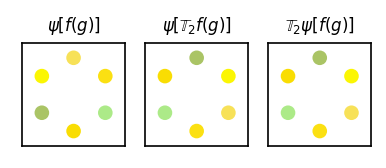

In [8]:
c1 = conv(z6_fxn, z6_phi)
c2 = trans_input_out
c3 = trans_output_out
titles = [r'$\psi\left[f(g)\right]$', r'$\psi\left[\mathbb{T}_2f(g)\right]$', r'$\mathbb{T}_2\psi\left[f(g)\right]$']

def sigmoid(x):  
    return 1 / (1 + np.exp(-x))

def convert_color(r, g, b):    
    h = int(sigmoid(r) * 256**3 + sigmoid(g) * 256**2 + sigmoid(b) * 256)
    return '#{:6X}'.format(h)

c1 = [sigmoid(c1(i)) for i in range(6)]
c2 = [sigmoid(c2(i)) for i in range(6)]
c3 = [sigmoid(c3(i)) for i in range(6)]

fig, axs = plt.subplots(1, 3, squeeze=True, figsize=(3, 9), dpi=150)
points = np.array([(0,1), (0.5 * np.sqrt(3), 0.5), (0.5 * np.sqrt(3), -0.5), (0, -1), (-0.5 * np.sqrt(3), -0.5), (-0.5 * np.sqrt(3), 0.5)])
for i in range(3):
    axs[i].scatter(points[:,0], points[:,1], color=[c1, c2, c3][i])
    #plt.plot([0, points[0,0]], [0, points[0, 1]], color='black', zorder=0) 
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_xlim(-1.4, 1.4)
    axs[i].set_ylim(-1.4, 1.4) 
    axs[i].set_aspect('equal')
    axs[i].set_title(titles[i], fontsize=8)
plt.show()

As you can see, our output looks the same if we apply the rotation either before or after, so our network is G-equivariant.

## G-Equivariant Convolutions with Translation

How can we treat the p4m group? We cannot directly use the continuous convolution definition because the rotations/mirror subgroup is finite and we cannot use the finite convolution because the translation subgroup is locally compact (infinitely many elements). Instead, we will exploit the structure of the group: it is constructed via a semidirect product so each group element is a pair of elements. Namely we can rewrite Equation 8.6 using the constituent subgroups $N \rtimes H$ and writing elements $g = hn, g^{-1} = n^{-1}h^{-1}$.

```{margin}
Remember that $g = nh$ is fine to use because $(n, e_r)\cdot (e_n, h) = (n, h)$, whereas the reverse requires using the conjugation $\phi(h)(n)$ (not to be confused with the kernel $\phi(g)$).
```

\begin{equation}
(f * \phi)(u) = \sum_{n \in N}\sum_{h \in H} f\uparrow^G\left(un^{-1}h^{-1}\right)\phi(hn)
\end{equation}

Now we must treat the fact that there are an infinite number of elements in $N$ (the translations). We can simply choose the kernel function ($\phi$) to only have support ($\phi(g) > 0$) at locations we want and that will simplify the integration. This may seem ad-hoc -- but remember we already made choices like not including 45° rotations. There do exist ways to systematically treat how to narrow the kernels into "neigbhorhoods" of groups in {cite}`finzi2020generalizing` or you can find a rigorous derivation specifically for p4 in {cite}`romero2020attentive` or {cite}`cohen2016group`.

```{margin}
I have a hidden cell below which does a bit of magic. It makes the group elements be hashable. That in turn allows me to cache my functions, enabling much faster speeds. This code would be unusable otherwise due to all the nested loops.
```

Our goal for the p4m group is image data, so we'll limit the support of the kernel to only integer translations (like pixels) and limit the distance to 5 units. This simply reduces our sum over the normal subrgroup ($N$). We can now begin our implementation. We'll start by loading an image which will serve as our function. It is a $64\times64$ RGB image. Remember that we need to allow points to have 3 dimensions, where the third dimension is always 1 to accommodate our augmented space.

In [9]:
# From https://gist.github.com/Susensio/61f4fee01150caaac1e10fc5f005eb75

from functools import lru_cache, wraps
import numpy as np


def np_cache(*args, **kwargs):
    """LRU cache implementation for functions whose FIRST parameter is a numpy array
    >>> array = np.array([[1, 2, 3], [4, 5, 6]])
    >>> @np_cache(maxsize=256)
    ... def multiply(array, factor):
    ...     print("Calculating...")
    ...     return factor*array
    >>> multiply(array, 2)
    Calculating...
    array([[ 2,  4,  6],
           [ 8, 10, 12]])
    >>> multiply(array, 2)
    array([[ 2,  4,  6],
           [ 8, 10, 12]])
    >>> multiply.cache_info()
    CacheInfo(hits=1, misses=1, maxsize=256, currsize=1)
    
    """
    def decorator(function):
        @wraps(function)
        def wrapper(np_array, *args, **kwargs):
            hashable_array = array_to_tuple(np_array)
            return cached_wrapper(hashable_array, *args, **kwargs)

        @lru_cache(*args, **kwargs)
        def cached_wrapper(hashable_array, *args, **kwargs):
            array = np.array(hashable_array)
            return function(array, *args, **kwargs)

        def array_to_tuple(np_array):
            """Iterates recursivelly."""
            try:
                return tuple(array_to_tuple(_) for _ in np_array)
            except TypeError:
                return np_array

        # copy lru_cache attributes over too
        wrapper.cache_info = cached_wrapper.cache_info
        wrapper.cache_clear = cached_wrapper.cache_clear

        return wrapper

    return decorator

In [10]:
# load image and drop alpha channel
W = 32
func_vals = plt.imread('quadimg.png')[...,:3]
# we pad it with zeros to show boundary
func_vals = np.pad(func_vals, ((1,1), (1,1), (0,0)), mode='constant', constant_values=0.2)
def pix_func(x):
    # clip & squeeze & round to account for transformed values
    xclip = np.squeeze(np.clip(np.round(x), -W // 2 - 1, W // 2)).astype(np.int)
    # points are centered, fix that        
    xclip += [W // 2, W // 2, 0]
    # add 1 to account for padding
    return func_vals[xclip[...,0] + 1, xclip[...,1] + 1]
#pix_func(np.array([[-65, -65,1], [14, -65,1], [W // 2, 4,0], [W // 2, W//2,4]]))

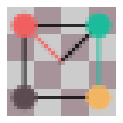

In [11]:
def plot_func(f, ax=None):
    if ax is None:
        plt.figure(figsize=(2, 2))
        ax = plt.gca()
    gridx,gridy = np.meshgrid(np.arange(-W // 2, W // 2), np.arange(-W // 2, W // 2), indexing='ij')        
    # make it into batched x,y indices and add dummy 1 indices for augmented space
    batched_idx = np.vstack((gridx.flatten(), gridy.flatten(), np.ones_like(gridx.flatten()))).T
    ax.imshow(f(batched_idx).reshape(W, W, 3), origin='upper')
    ax.axis('off')
plot_func(pix_func)

Now let's define our G-function transform so that we can transform our function with group elements. We'll apply a $rst_{12,-8}$ element to our function.

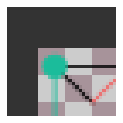

In [12]:
def make_h(rot, mirror):
    '''Make h subgroup element'''
    m = np.eye(3)
    if mirror:
        m = np.array([[-1,0,0],[0,1,0],[0,0,1]])
    r = np.array([[np.cos(rot), -np.sin(rot), 0], [np.sin(rot), np.cos(rot), 0], [0, 0, 1]])
    return r @ m
def make_n(dx, dy):
    '''Make normal subgroup element'''
    return np.array([[1, 0, dx], [0, 1, dy], [0, 0, 1]])
def g_func_trans(g, f):
    '''compute g-function transform'''
    @np_cache(maxsize=W**3)
    def fxn(x, g=g, f=f):
        ginv = np.linalg.inv(g)
        return f(ginv.reshape(1, 3, 3) @ x.reshape(-1, 3, 1))
    return fxn

g = make_h(np.pi, 1) @ make_n(12, -8)
tfunc = g_func_trans(g, pix_func)
plot_func(tfunc)

Now we need to create our lifting and projecting maps to go from functions over points to functions over group elements. Remember, our lifting function just takes the translation element and makes that point. 

In [13]:
stabilizer = []
for i in range(4):
    for j in range(2):
        stabilizer.append(make_h(i * np.pi / 2, j))

def lift(f):
    '''lift f into group'''
    # just slice translation component of g matrix
    @np_cache(maxsize=W**3)
    def fxn(g, f=f):
        return f(g @ np.array([0, 0, 1]))
    return fxn


def project(f):
    '''create projected function over space'''
    @np_cache(maxsize=W**3)
    def fxn(x, f=f):
        # x may be batched so we have to allow it to be N x 2
        x = np.array(x).reshape((-1,3))
        out = np.zeros((x.shape[0], 3))
        for i,xi in enumerate(x):
            # find coset gH        
            g = make_n(xi[0], xi[1])
            # loop over coset
            for h in stabilizer:
                # using conjugate to get gH
                ghi = g @ h
                out[i] += f(ghi)
            out[i] /= len(stabilizer)
        return out
    return fxn
# try them out
print('lifted', lift(pix_func)(g))
print('projected', project(lift(pix_func))([12, -8, 0]))

lifted [0.93333334 0.7176471  0.43137255]
projected [[0.72941178 0.71764708 0.72156864]]


We now need to create our kernel functions $\phi$. Rather than make a function of the group elements, we'll use indices to represent the different group elements. Remember we need to apply a sigmoid at the end so that we stay in color space. 

In [14]:
kernel_width = 5 # must be odd
kernel = np.random.uniform(-0.2, 0.2, size=(len(stabilizer), kernel_width, kernel_width, 3, 3))

def conv(f, p=kernel):
    @np_cache(maxsize=W**4)
    def fxn(u):
        # It is possible to do this without inner for 
        # loops over convolution. 
        result = 0
        for hi,h in enumerate(stabilizer):
            for nix in range(-kernel_width // 2, kernel_width // 2 + 1):
                for niy in range(-kernel_width // 2, kernel_width // 2 + 1):
                    result += f(u @ 
                      make_n(-nix, -niy) @ \
                      np.linalg.inv(h)) @\
                    kernel[hi, nix + kernel_width // 2, niy + kernel_width // 2]
        return sigmoid(result)
    return fxn
cout = conv(lift(pix_func))
cout(g)

array([0.28153808, 0.64737821, 0.86913879])



At this point our convolution layer has returned a function over all group elements. We can visualize this by viewing each stabilizer element individually across the normal subgroup. This is like plotting each coset with a choice of representative element.

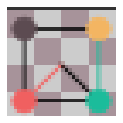

In [15]:
def plot_coset(h, f, ax):    
    '''plot a function over group elements on cosets given representative g'''
    gridx,gridy = np.meshgrid(np.arange(-W // 2, W // 2), np.arange(-W // 2, W // 2), indexing='ij')        
    # make it into batched x,y indices and add dummy 1 indices for augmented space
    batched_idx = np.vstack((gridx.flatten(), gridy.flatten(), np.ones_like(gridx.flatten()))).T
    values = np.zeros((W**2, 3))
    for i, bi in enumerate(batched_idx):
        values[i] = f(h @ make_n(bi[0], bi[1]))
    ax.imshow(values.reshape(W, W, 3), origin='upper')    
    ax.axis('off')
# try it with mirror
plt.figure(figsize=(2, 2))
plot_coset(make_h(0, 1), lift(pix_func), ax=plt.gca())

Now we will plot our convolution for each possible coset representative. This code is *incredibly* inefficient because we have so many loops in plotting and the convolution. This is where the `np_cache` from above helps. 

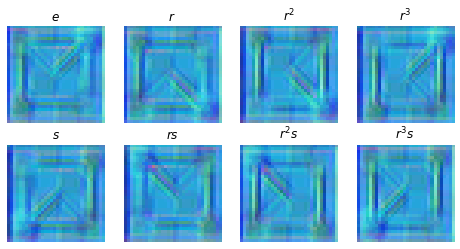

In [16]:
stabilizer_names = ['$e$', '$r$', '$r^2$', '$r^3$', '$s$', '$rs$', '$r^2s$', '$r^3s$']
fig, axs = plt.subplots(2, 4, figsize=(8,4))
axs = axs.flatten()
for i, (n,h) in enumerate(zip(stabilizer_names, stabilizer)):
    ax = axs[i]
    plot_coset(h, cout, ax)
    ax.set_title(n)    

These convolutions are untrained, so it's sort of a diffuse random combination of pixels. You can see each piece of the function broken out by stabilizer group element (the rotation/mirroring). We can stack multiple layers of these convolution if we wanted. At the end, we want to get back to our space with the projection. 
Let us now show our layers are equivariant by applying a G-function transform to input and output. 

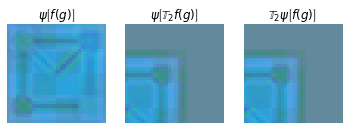

In [17]:
fig, axs = plt.subplots(1, 3, squeeze=True)

#out = conv(lift(pix_func))

plot_func(project(cout), ax=axs[0])
axs[0].set_title(titles[0])

g = make_h(np.pi, 0) @ make_n(-10, 16)
tfunc = g_func_trans(g, project(cout))
plot_func(tfunc, ax=axs[1])
axs[1].set_title(titles[2])

tcout = project(conv(lift(g_func_trans(g, pix_func))))

plot_func(tcout, ax=axs[2])
axs[2].set_title(titles[1])
plt.show()

This shows that the convolution layer is indeed equivariant. Details not covered here are how to do pooling (if desired) and the choice of non-linearity. You can find more details on this for the p4m group in Cohen et al. {cite}`cohen2016group`. This implementation is also quite slow! Kondor et al. {cite}`kondor2018generalization` show how you can reduce the number of operations by identifying sparsity in the convolutions. 

## Group Representation

p4m was an infinite group but we restricted ourselves to a finite subset. Before we can progress to move to truly infinite locally compact groups, like SO(3), we need to learn how to systematically represent the group element binary operation. You can find a detailed description of representation theory in Serre {cite}`serre1977linear`. Thus far, we've discussed the group actions -- how they affect a point. Now we need to describe how to represent them with matrices. This will be a very quick overview of this topic, but representation of groups is a large area with well-established references. There is specifically a great amount of literature about building up these representations, but we'll try to focus on using them since you generally can look-up the representations for most groups we'll operate in. 

Let us first define a representation on a group:

```{admonition} Linear Representation of a Group
Let $G$ be a group on an $n$-dimensional vector space $\mathcal{X}$ . A linear representation of $G$ is a group homomorphism: $\rho: G \rightarrow GL(m,\mathbb{C})$ where $GL(m, \mathbb{C})$ is the space of $m\times m$ square invertible matrices with complex numbers. The representation $\rho$ should satisfy the following equation

\begin{equation}
\label{rep-def}
\rho\left(g_1\cdot g_2\right) = \rho\left(g_1\right) \rho\left(g_2\right)\; \forall\, g_1,g_2 \in G
\end{equation}

where the term $\rho\left(g_1\right) \rho\left(g_2\right)$ is a matrix product. 
```

There are a few things to note about this definition. First, the representation assigns matrices to graph elements in such a way that multiplying matrices gives the same representation as getting the representation of the binary operation ($\rho\left(g_1\cdot g_2\right)$). Second, the matrices have to be square and invertible. This follows from the requirement that group elements must have an inverse, so naturally we need invertible matrices. The invertible requirement also means we must allow complex numbers. Third, the **degree** of the representation ($m$) need not be the same size as the vector space. 

There is a big detail missing from this definition. Does this have anything to do with how the group element affect a point? No. The way a group affects a point the **group action**, which maps from the direct product of $G, \mathcal{X}$ (i.e., a tuple like $(g_2, x)$ to $\mathcal{X}$. Yet a group action is also a representation and a *linear* group action can form a matrix representation. Consider we write the group action $\pi$ (how a group element affects a point) as $\pi(g)(x) = x'$. You can convert this into a square matrix in $\mathcal{X}\times\mathcal{X}$ by considering how each element of $x'$ is affected the element in $x$. This matrix can be further shown to be in $GL(m, \mathcal{X})$ and a representation by relying on its linearity. A combined linear group action and representation constructed this way is sometimes called the **regular representation.**


*We've simplified the problem of finding a representation to creating a matrix that describes how a point is transformed for any group element $g$ called a linear group action.* I will mention one more way you can construct representations via **induced representations**. If you are unable to construct a representation or group action directly and your group was constructed via a semidirect or direct product, you can build it by first defining a representation on a *normal* subgroup $H$ and then use an **induced action** to create a representation of the whole group $G$.


Let's now see our group representations on the examples. 


```{tabbed} ⬡ Finite Group $Z_6$ 

Our group action defined above was modular arithmetic, which is not linear and so we cannot use it to construct representation. There are multiple representation for this group. If you're comfortable with complex numbers, you can build circulant matrices of $6$th roots of unity. If that confuses you, like it does me, then you can also just view this group like a rotation group. Just like how if you rotate enough times you get back to the beginning, you can also use rotation matrices of $360 / 6 = 60^{\circ}$. This requires a 2D vector representation though for the space. With this choice, the regular representation is:

$$
\left[\begin{array}{lr}
\cos\frac{k2\pi}{6} & -\sin\frac{k2\pi}{6}\\
\sin\frac{k2\pi}{6} & \cos\frac{k2\pi}{6}\\
\end{array}\right],\, k \in \left\{0, 1, 2, 3, 4, 5\right\}
$$

Let's verify that this is a representation by checking that $r^2\cdot\,r^4 = e$

$$
\left[\begin{array}{lr}
\cos\frac{4\pi}{6} & -\sin\frac{4\pi}{6}\\
\sin\frac{4\pi}{6} & \cos\frac{4\pi}{6}\\
\end{array}\right]\left[\begin{array}{lr}
\cos\frac{8\pi}{6} & -\sin\frac{k2\pi}{6}\\
\sin\frac{8\pi}{6} & \cos\frac{8\pi}{6}\\
\end{array}\right] = \left[\begin{array}{lr}
\cos\frac{12\pi}{6} & -\sin\frac{12\pi}{6}\\
\sin\frac{12\pi}{6} & \cos\frac{12\pi}{6}\\
\end{array}\right] = \left[\begin{array}{lr}
1 & 0\\
0 & 1\\
\end{array}\right]
$$

You can also verify that this is a group action by repeated application to the point $(1,0)$, which will rotate around the unit circle. 

```

```{tabbed} ▩ Locally Compact p4m

Our group action defined above for the translation elements is not linear. To define a regular representation, we can use [**Affine Matrices**]() which are $3\times3$ invertible square matrices. That means even though our goal is 2D data, we need to introduce a 3rd dimension: $(x, y, 1)$. The 3rd dimension is always $1$ and is called the augmented dimension. To specify a group representation we simply need to multiply an affine matrix for rotation, reflection, and translation (*in that order!*). These are:

Rotation:

$$
\left[\begin{array}{lcr}
\cos\frac{k\pi}{4} & -\sin\frac{k\pi}{4} & 0\\
\sin\frac{k\pi}{4} & \cos\frac{k\pi}{4} & 0\\
0 & 0 & 1\\
\end{array}\right] ,\, k \in \left\{0, 1, 2, 3\right\}
$$

Reflection:

$$
\left[\begin{array}{lcr}
1 & 0 & 0\\
0 & -1 & 0\\
0 & 0 & 1\\
\end{array}\right]
$$

Translation:

$$
\left[\begin{array}{lcr}
1 & 0 & \Delta x\\
0 & 1 & \Delta y\\
0 & 0 & 1\\
\end{array}\right]
$$

It is a bit more involved to verify this is a group representation, but you can try a few group element products to convince yourself. Do not forget the special homomorphism (conjugate $\phi(h)(n)$) for semidirect products when multiplying group element, which ensures the correct behavior if rearrange the order of the matrices. 

```


```{tabbed} ⚽ SO(3) Lie Group

The regular representation of the SO(3) lie group is just its usual group action: the product of 3 3D rotation matrices $R_z(\alpha)R_y(\beta)R_z(\gamma)$ where $\alpha, \beta, \gamma \in [0, 2\pi]$ and the matrices are defined above.

```

How do we show that p4m group is just a sum over group. I don't think we need the complete group representation right? It's an induced action? https://planetmath.org/inducedrepresentation? We want the representation on rot/mirror - something like representation of g acting on f(x) is $\rho(h(g^{-1}, x)^{-1})f(g^{-1}x)$ where $h$ at $(g^{-1}x)$ is like finding the h at that point. Wait -- maybe we don't need this, we can just read off the restricted convolutiosn from kondor paper -- yes. also, we shouuld define group action earlier and then this section will make more sense 

### Irreducible representations

These representations that both describe the group action and how group elements affect on another are typically **reducible**, meaning if you drop the requirement that they also describe group action they can be simplified. The process of reducing representations is again a topic best left to another reference and/or looked-up. These irreducible representations are like orthonormal basis-functions or basis-vectors from Hilbert spaces. We'll use them for Fourier transforms in a moment. One important fact you should know is that they can be complex and if a group is non-abelian there will be matrices. That means the individual representations can have different dimensions. From now on, I will only continue the locally compact examples since we already saw how to easily treat finite groups. 







Intro video: https://www.youtube.com/watch?v=mH0oCDa74tE

Convolutions are only way to go: https://arxiv.org/abs/1806.09231

homogenuous -> you can reach any point with a group. 

best theory (I think) https://arxiv.org/pdf/1802.03690.pdf
similar but with fiber bundles/cosets -> https://arxiv.org/pdf/1811.02017.pdf

induced action -> group element acting on function. Induced space -> space of that (?)


some people say covariant -> group element on input != group element on output

Let's start with G-CNN which I'm having trouble understanding:

Presentation on locally compact groups -> https://galton.uchicago.edu/mart/slides/Kondor_Fourier.pdf

commutative -> representations are complex scalars (FFT is easy). Called LCA (locally compact abelian)     

$$
[f * \psi](g) = \frac{1}{|G|}\sum_{x}
$$

## Outline

Maybe start with finite group, conclude with G-CNN 

Then move to compact groups

then move to permutations

1. Finite Groups and use molecular structure example  https://en.wikipedia.org/wiki/Molecular_symmetry
2. Representations, irreps -- finding them https://www.jstor.org/stable/2004848?seq=1#metadata_info_tab_contents, https://en.wikipedia.org/wiki/Group_representation, character tables - https://www.chem.uci.edu/~lawm/10-2.pdf package: https://gemmi.readthedocs.io/en/latest/symmetry.html#operations - does not include permutation symmetry
3. functions on them -> an image is a function, molecular coordiates are a function, we're learning a function (?)Does that mean layers are operators? Guess so
4. define equivariance 
5. equivariant neuron - Show group CNN first, then Kondor construction
6. examples
7. survey of field
8. meta learning these: https://arxiv.org/pdf/2007.02933.pdf

G-CNN - easy for discrete groups. http://proceedings.mlr.press/v48/cohenc16.pdf
could use for all point groups too - depends on number of group elements. 

DeepSets - https://proceedings.neurips.cc/paper/2017/file/f22e4747da1aa27e363d86d40ff442fe-Paper.pdf
equivariant strategy for networks. This defines them using convolutions - https://arxiv.org/pdf/2004.03990.pdf. Here is the hierarchical variant: https://proceedings.neurips.cc//paper_files/paper/2020/hash/9efb1a59d7b58e69996cf0e32cb71098-Abstract.html - they use MLPs with weight sharing. Is that equivalent to group convolutions? Average over groups strategy -> equation 44 in https://arxiv.org/pdf/2004.05154.pdf. Maybe average over groups = convolution (aka correlation). Yes, it does. However, you do not have to average. You can keep each independent component. The averaging comes from the pooling. Averaging moves to a coset (removing a part of the group) and moves you to a quoteint space (see 6.5 in G-CNN ppaer). 

Icosohedron convs enforce weight sharing in their convolutions - https://arxiv.org/pdf/1902.04615.pdf

The Clepsh-Gordon approach doesn't use a convolution, but instead a product in spectral (fourier) space. 

Fiber bundles and fields intro. Proves convolutions are only way to do it. 

https://arxiv.org/pdf/1811.02017.pdf

Notation - you can refer to the irreducible representations of SO3 (momentum numbers, l = ) as fragments

ok modern permutation invariant -> https://arxiv.org/pdf/2004.03990.pdf. Maybe not that interesting (second order permutations are interesting), but reconciles the locally compact groups being fourier convolutions with permutations. 

Can approximate convolutions with quadrature (MC integration) https://arxiv.org/pdf/2002.12880.pdf instead of using Fourier Space

0 0


0 1


1 0


1 1


2 0


2 1


3 0


3 1


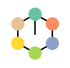

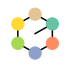

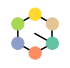

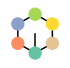

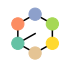

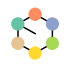

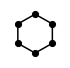

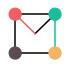

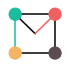

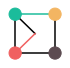

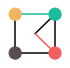

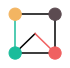

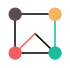

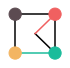

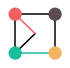

In [20]:
from myst_nb import glue

def hexico(rot):
    cmap = plt.get_cmap('Set2')        
    colors = [cmap(i / 6) for i in range(6)]
    points = np.array([(0,1), (0.5 * np.sqrt(3), 0.5), (0.5 * np.sqrt(3), -0.5), (0, -1), (-0.5 * np.sqrt(3), -0.5), (-0.5 * np.sqrt(3), 0.5)])
    # wrap the points
    index = [(i + rot) % 6 for i in range(6)]
    points = points[index]
    plt.figure(figsize=(1, 1))        
    if rot == 6:
        plt.scatter(points[:,0], points[:,1], marker='.', color='black', s=150)
    else:
        plt.scatter(points[:,0], points[:,1], marker='o', c=colors, s=150)
        plt.plot([0, points[0,0]], [0, points[0, 1]], color='black', zorder=0)    
        
    plt.plot(points[:, 0], points[:, 1], color='black', zorder=0)
    plt.plot([points[-1, 0], points[0, 0]],  [points[-1, 1], points[0, 1]], color='black', zorder=0)
    plt.xticks([])
    plt.yticks([])
    plt.xlim(-1.4, 1.4)
    plt.ylim(-1.4, 1.4)    
    for s in plt.gca().spines.values():
        s.set_visible(False)
    glue(f'hex-{rot}', plt.gcf(), display=False)
for i in range(7):
    hexico(i)
    
def quad(rot, mirror):
    colors = color_cycle[:4]
    points = np.array([(1, 1), (-1, 1), (-1, -1), (1, -1)])
    if mirror:
        points[:,0] *= -1
    # wrap the points
    index = [(i + rot) % 4 for i in range(4)]
    points = points[index]
    plt.figure(figsize=(1, 1))        
    plt.scatter(points[:,0], points[:,1], marker='o', c=colors, s=150)
    plt.plot([0, points[0,0]], [0, points[0, 1]], color='black', zorder=0)    
        
    plt.plot(points[:, 0], points[:, 1], color='black', zorder=0)
    plt.plot([points[-1, 0], points[0, 0]],  [points[-1, 1], points[0, 1]], color='C0', zorder=0)
    plt.plot([0, points[1, 0]],  [0, points[1, 1]], linestyle='-', color='C1', zorder=0)
    plt.xticks([])
    plt.yticks([])
    plt.xlim(-1.4, 1.4)
    plt.ylim(-1.4, 1.4)    
    for s in plt.gca().spines.values():
        s.set_visible(False)
    print(rot, mirror)
    glue(f'quad-{rot}-{mirror}', plt.gcf(), display=False)
for i in range(4):
    for j in range(2):
        quad(i, j)

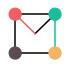

In [21]:
colors = color_cycle[:4]
points = np.array([(1, 1), (-1, 1), (-1, -1), (1, -1)])
index = range(4)
points = points[index]
plt.figure(figsize=(1, 1))        
plt.scatter(points[:,0], points[:,1], marker='o', c=colors, s=150)
plt.plot([0, points[0,0]], [0, points[0, 1]], color='black', zorder=0)    

plt.plot(points[:, 0], points[:, 1], color='black', zorder=0)
plt.plot([points[-1, 0], points[0, 0]],  [points[-1, 1], points[0, 1]], color='C0', zorder=0)
plt.plot([0, points[1, 0]],  [0, points[1, 1]], linestyle='-', color='C1', zorder=0)
plt.xticks([])
plt.yticks([])
plt.xlim(-1.4, 1.4)
plt.ylim(-1.4, 1.4)    
for s in plt.gca().spines.values():
    s.set_visible(False)
plt.savefig('quad.svg')

## Cited References

```{bibliography} references.bib
```